# Tech Challenge 1 - Machine Learning

Tech Challenge é o projeto que engloba os conhecimentos obtidos em todas as disciplinas dessa fase. Esta é uma atividade que, em princípio, deve ser desenvolvida em grupo. É importante atentar-se ao prazo de entrega, uma vez que essa atividade é obrigatória, valendo 90% da nota de todas as disciplinas da fase.

## 1. O problema

Você é um(a) profissional encarregado(a) de desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.

### 1.1. Base Escolhida
[US Health Insurance Dataset](https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset) do Kaggle

**Descrição no Kaggle:** "This dataset contains 1338 rows of insured data, where the Insurance charges are given against the following attributes of the insured: Age, Sex, BMI, Number of Children, Smoker and Region. The attributes are a mix of numeric and categorical variables."

Primeiramente vamos carregar a base:

In [88]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

try:
    df_insurance = pd.read_csv('insurance.csv')
except FileNotFoundError:
    print("Error: 'insurance.csv' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

## 2. Exploração de dados

Avliando o formato do arquivo:

In [89]:
df_insurance.shape

(1338, 7)

Temos 1338 linhas em 7 colunas.  

Vamos ver quais são os tipos e as nulidades:

In [90]:
df_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Ótimo, por sorte não temos nulos nessa base!

Mas os nomes das colunas não estão muito claros, para facilitar a compreensão, trazemos a descrição dos campos:

- **age**: Idade do beneficiário principal  
- **sex**: Gênero do contratante do seguro
- **bmi**: Índice de massa corporal (IMC).  
- **children**: Número de dependentes  
- **smoker**: Fumante / Não fumante  
- **region**: Região de residência do beneficiário nos EUA
- **charges**: Custos médicos individuais cobrados pelo seguro de saúde  

Agora vamos dar uma olhadinha nos dados:

#### Primeiras linhas da base

In [91]:
#5 primeiros
df_insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Ultimas linhas da base

In [92]:
#5 ultimos
df_insurance.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


#### Valores únicos na base

In [93]:
# checando unicos
df_insurance.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

#### Quantidade de linhas x colunas

In [94]:
#rows*columns
df_insurance.size

9366

Já temos uma boa noção dos dados!  
Agora vamos ver como eles estão distribuídos:

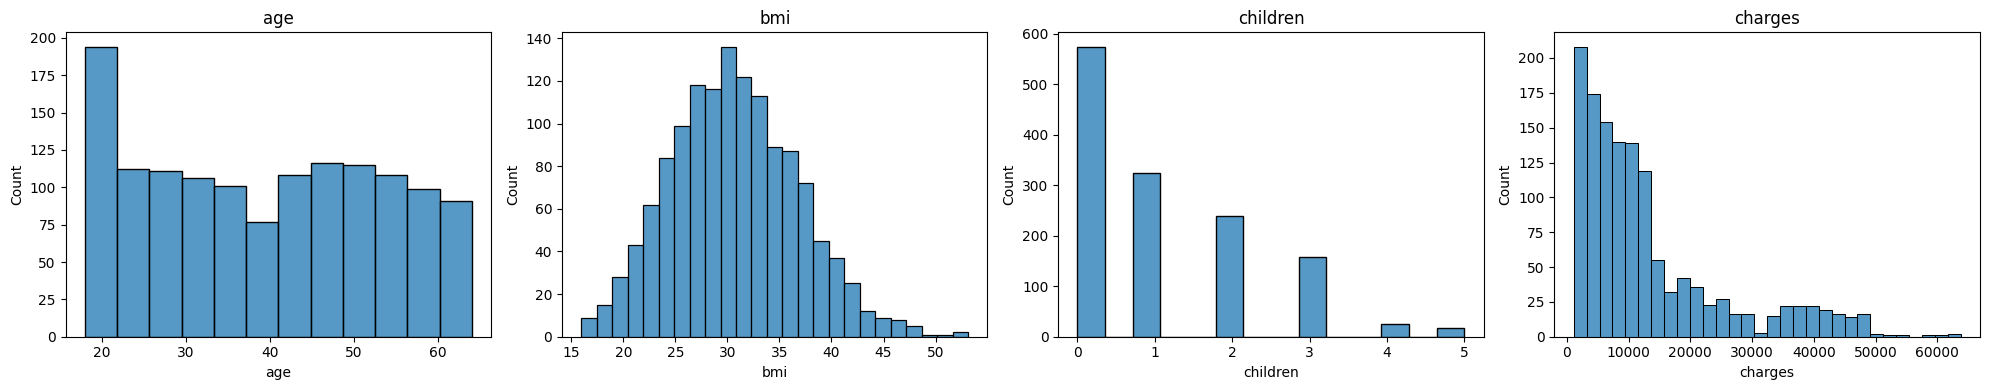

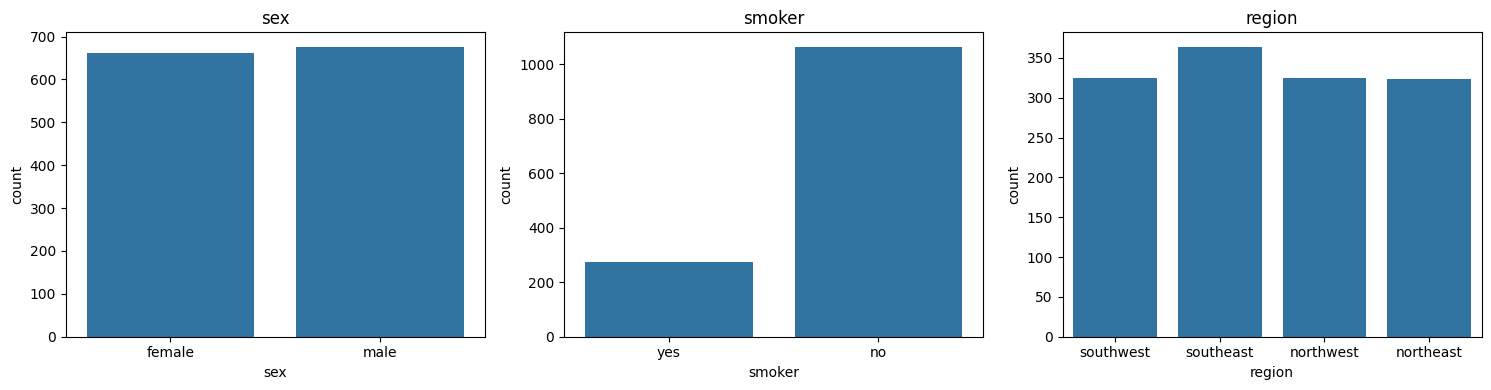

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numerical_cols = df_insurance.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_insurance.select_dtypes(include=['object']).columns

def plot_multiple(columns, plot_func, plots_per_row=3):
    total = len(columns)
    rows = math.ceil(total / plots_per_row)
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row*5, rows*4))

    for idx, col in enumerate(columns):
        plt.sca(axes[idx])
        plot_func(col)
        axes[idx].set_title(col)

    for idx in range(total, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

def plot_hist(col):
    sns.histplot(df_insurance[col])

def plot_count(col):
    sns.countplot(data=df_insurance, x=col)

plot_multiple(numerical_cols, plot_hist, plots_per_row=4)
plot_multiple(categorical_cols, plot_count, plots_per_row=4)

Os dados estão bem distribuidos, exceto por dois pontos:
- Os "não fumantes" são 5x menos representativos que os "fumantes".
- O "custo" (charges) também acabou ficando estranho, porque após o 50mil tem bem pouco em cada faixa.

Caso o modelo de predição não fique muito bom, podemos fazer duas coisas:
- Aumentar os "não fumante" com oversample
- Remover os outliers do Custo

Agora vamos dar uma olhada na correlação entre os dados.

In [96]:
df_insurance['sex'] = df_insurance['sex'].map({'male': 0, 'female': 1})
df_insurance['smoker'] = df_insurance['smoker'].map({'no': 0, 'yes': 1})
df_insurance['region'] = df_insurance['region'].map({'northeast':0, 'northwest':1, 'southeast':2, 'southwest':3})

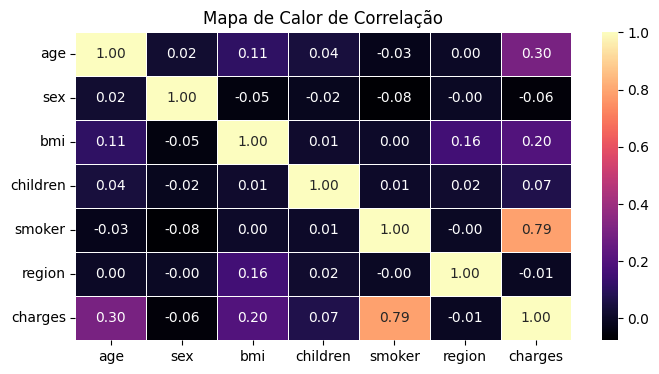

In [97]:
corr = df_insurance.corr()
plt.figure(figsize=(8,4))
sns.heatmap(
    corr,
    annot=True,
    cmap='magma',
    fmt='.2f',
    linewidths=0.5,
)
plt.title('Mapa de Calor de Correlação')
plt.show()

A correlação fez sentido, o Valor do seguro é diretamente afetado por: Vícios (fumante), Idade e IMC.   

Existe uma pequena correlação entre Região e IMC... Não fez sentido pra mim.

Agora que sabemos quais são os principais valores correlacionados, vamos dar uma olhada em como eles se relacionam com o Valor do Seguro.

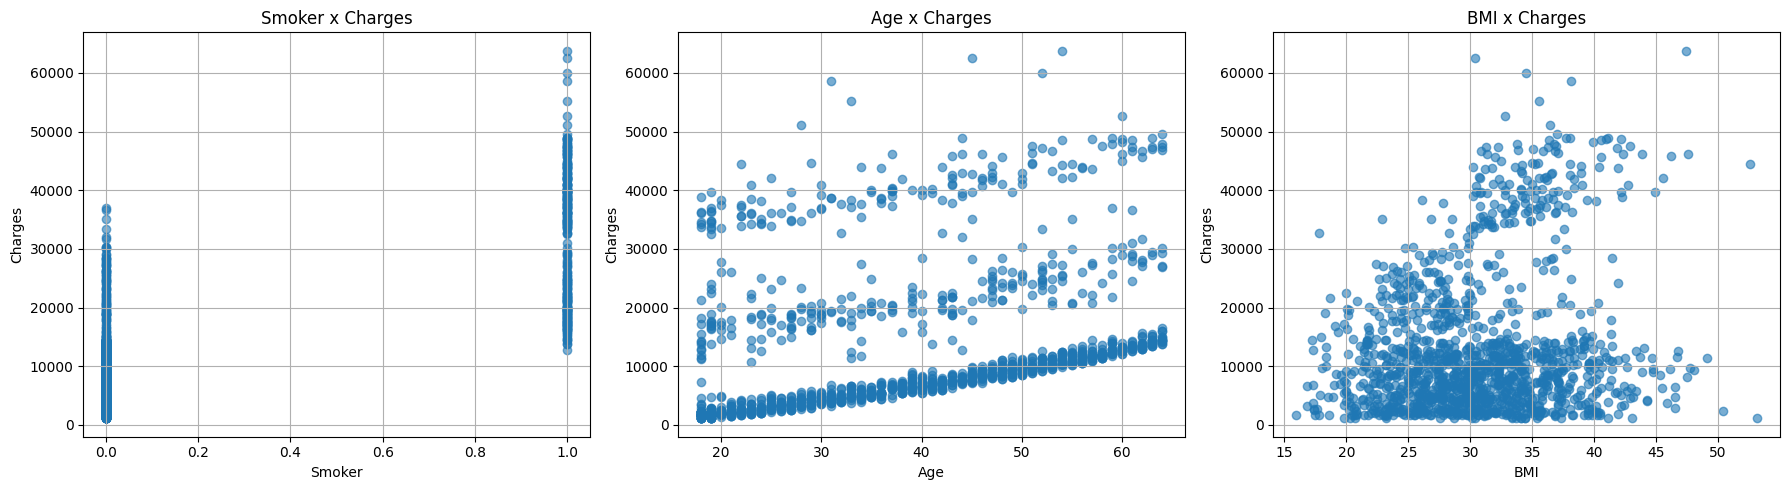

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_insurance['smoker'], df_insurance['charges'], alpha=0.6)
axes[0].set_title('Smoker x Charges')
axes[0].set_xlabel('Smoker')
axes[0].set_ylabel('Charges')
axes[0].grid(True)

axes[1].scatter(df_insurance['age'], df_insurance['charges'], alpha=0.6)
axes[1].set_title('Age x Charges')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Charges')
axes[1].grid(True)

axes[2].scatter(df_insurance['bmi'], df_insurance['charges'], alpha=0.6)
axes[2].set_title('BMI x Charges')
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Charges')
axes[2].grid(True)

plt.tight_layout()
plt.show()

**Smoker X Charges**: Claramente os fumantes ficaram com o maior custo. Na faixa dos 15mil a 35mil tem uma mistura, mas nenhum fumante paga pouco, assim como nenhum "não fumante" paga muito.

**Age X Charges**: Esse foi o mais interessante!!!! Claramente há 3 faixas de valores! Vamos descobrir o motivo disso.

**BMI x Charges**: Acima de 30 BMI (obeso), os preços sobem... Mas não pra todos. O que faz o preço subir mais? 

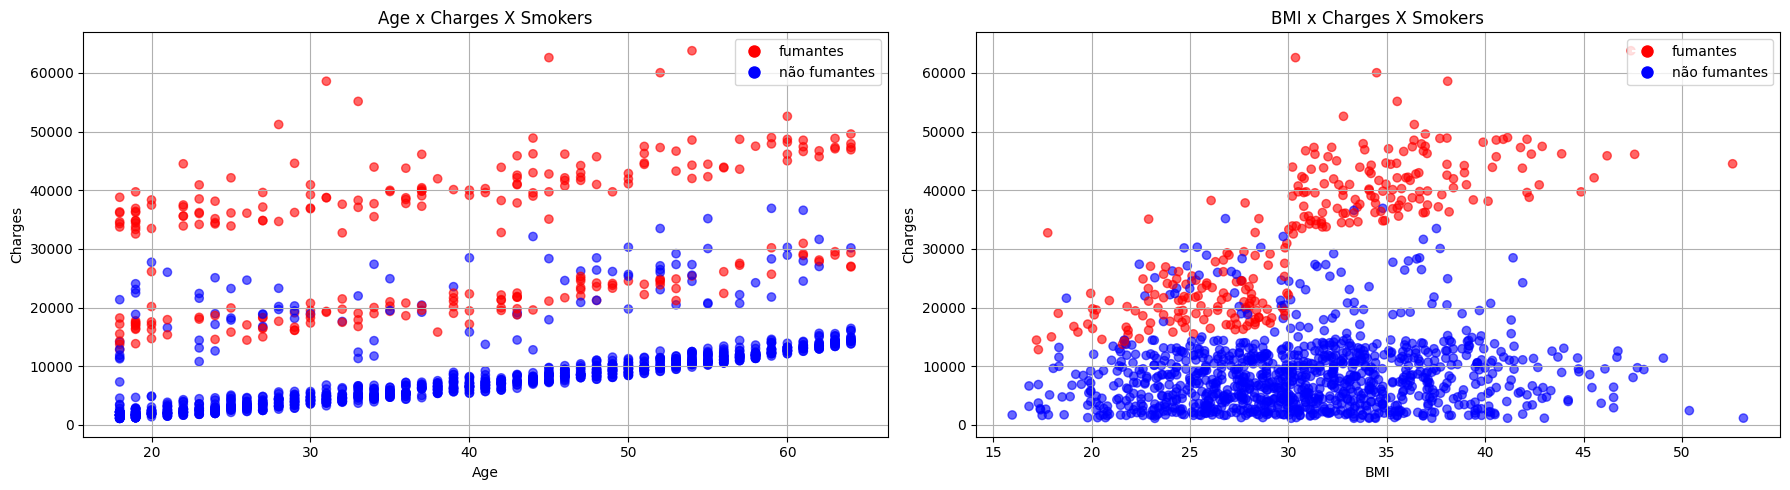

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

colors = df_insurance['smoker'].map({0: 'blue',1: 'red'})

axes[0].scatter(
    x=df_insurance['age'],
    y=df_insurance['charges'],
    c=colors,
    alpha=0.6
)
axes[0].set_title('Age x Charges X Smokers')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')
axes[0].grid(True)

axes[1].scatter(
    x=df_insurance['bmi'],
    y=df_insurance['charges'],
    c=colors,
    alpha=0.6
)
axes[1].set_title('BMI x Charges X Smokers')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Charges')
axes[1].grid(True)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='fumantes', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='não fumantes', markerfacecolor='blue', markersize=10)
]
axes[0].legend(handles=legend_elements, loc='upper right')
axes[1].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

A observação de que havia 3 faixas ficou mais evidente agora! Claramente existe uma diferenciação de preço pra quem é fumante e obeso. Essa galera fica acima dos U$30.000. Independente da idade!

Existe uma faixa que vai dos 15.000 aos 30.000 que eu não sei do que é ainda. Não consegui identificar relação com sexo, região, quantidade de dependentes ou correlações entre os outros dados. Talvez sejam outliers ou sejam outros fatores que modificam o valor da cobrança que não estão presentes nessa base.

Vamos dar uma olhada nos outliers:

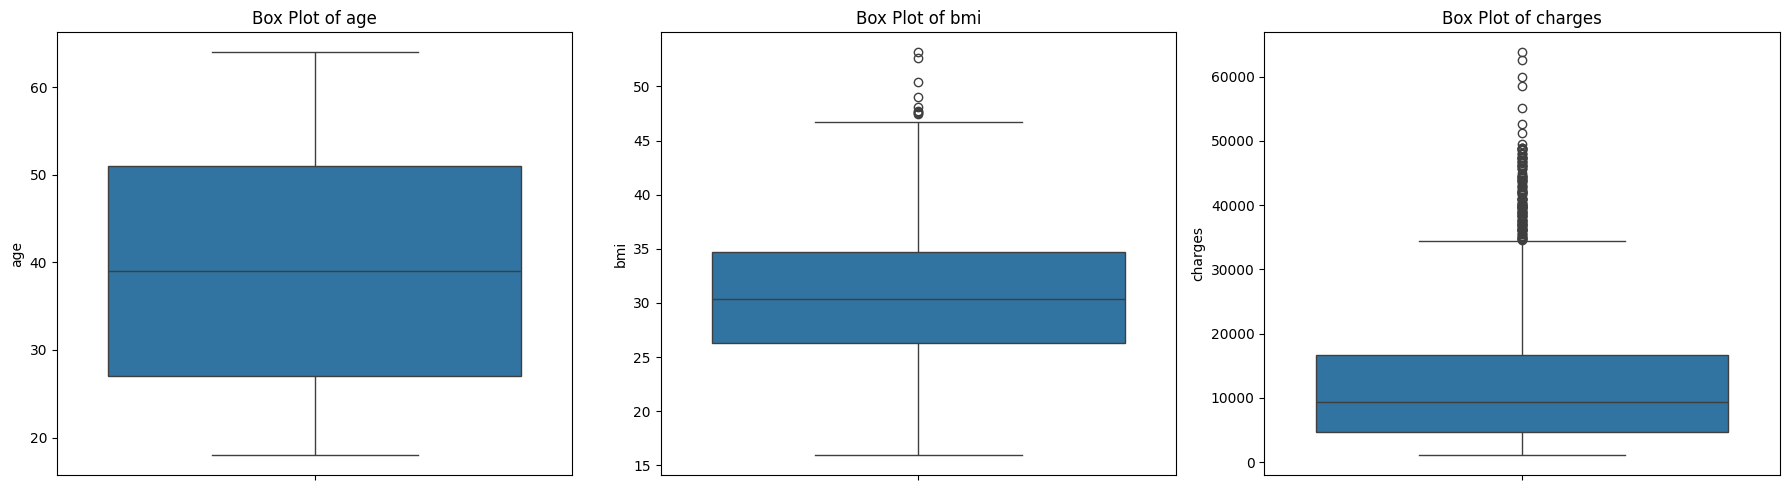

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plots para campos numericos
plt.figure(figsize=(18, 5))
for i, col in enumerate(['age', 'bmi', 'charges']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(y=df_insurance[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

O BMI e o Charges tem alguns Outliers, poderíamos remover eles antes do treinamento. 

## 3. Pré-processamento

### Limpeza

In [101]:
import numpy as np

# Usando Log para remover outlier de 'charges'
df_insurance['charges'] = np.log1p(df_insurance['charges'])

# Cortando o "bmi" no 99º percentil
bmi_99th = df_insurance['bmi'].quantile(0.99)
df_insurance['bmi'] = np.where(df_insurance['bmi'] > bmi_99th, bmi_99th, df_insurance['bmi'])

# Removendo outliers em 'age' e 'children'
age_99th = df_insurance['age'].quantile(0.99)
df_insurance = df_insurance[df_insurance['age'] <= age_99th]

children_99th = df_insurance['children'].quantile(0.99)
df_insurance = df_insurance[df_insurance['children'] <= children_99th]

numerical_cols = ['age', 'bmi', 'children', 'charges']

if df_insurance.isnull().values.any():
    
    for col in numerical_cols:
        if df_insurance[col].isnull().any():
            df_insurance[col] = df_insurance[col].fillna(df_insurance[col].median())
    print('Values nulos foram preenchidas com a mediana dos respectivos campos numéricos.')
else:
    print('Nenhum valor nulo encontrado nos campos numéricos.')

print("\n Descrilção estatisticas dos campos numericos após a limpeza: \n", df_insurance[numerical_cols].describe())

Nenhum valor nulo encontrado nos campos numéricos.

 Descrilção estatisticas dos campos numericos após a limpeza: 
                age          bmi     children      charges
count  1338.000000  1338.000000  1338.000000  1338.000000
mean     39.207025    30.643352     1.094918     9.098828
std      14.049960     6.039053     1.205493     0.919379
min      18.000000    15.960000     0.000000     7.023647
25%      27.000000    26.296250     0.000000     8.464064
50%      39.000000    30.400000     1.000000     9.146658
75%      51.000000    34.693750     2.000000     9.719618
max      64.000000    46.407900     5.000000    11.063061


### Conversão de dados

In [102]:
# Realizando one-hot encoding nos campos categóricos
df_encoded = pd.get_dummies(df_insurance, columns=['sex', 'smoker', 'region'], drop_first=True)

# Exibindo as primeiras linhas do DataFrame codificado
display(df_encoded.head())

,age,bmi,children,charges,sex_1,smoker_1,region_1,region_2,region_3
0,19,27.900,0,9.734236,True,True,False,False,True
1,18,33.770,1,7.453882,False,False,False,True,False
2,28,33.000,3,8.400763,False,False,False,True,False
3,33,22.705,0,9.998137,False,False,True,False,False
4,32,28.880,0,8.260455,False,False,True,False,False


# Modelagem

### Separação treino e teste

In [103]:
from sklearn.model_selection import train_test_split

# Definindo as variáveis independentes (X) e dependentes (y)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Separando os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_encoded['smoker_1']
)


# Treinamento e avaliação do modelo:

### Treinamento de modelo

In [112]:
# Modelo 1 - Regressão Linear
from sklearn.linear_model import LinearRegression

results = {}

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

results['Linear Regression'] = {
    'r2': r2_score(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'mae': mean_absolute_error(y_test, y_pred),
    'y_pred': y_pred
}

In [113]:
# Modelo 2 - Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

tree = GradientBoostingRegressor(random_state=42)
tree.fit(X_train, y_train)
y_pred_gbr = tree.predict(X_test)

results['Gradient Boosting'] = {
    'r2': r2_score(y_test, y_pred_gbr),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_gbr)),
    'mae': mean_absolute_error(y_test, y_pred_gbr),
    'y_pred': y_pred_gbr
}

In [114]:
# Modelo 3 - Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=7)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results['Random Forest'] = {
    'r2': r2_score(y_test, y_pred_rf),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'mae': mean_absolute_error(y_test, y_pred_rf),
    'y_pred': y_pred_rf
}

### Avaliação de modelo

                         r2      rmse       mae
Linear Regression  0.788322  0.428003  0.272718
Gradient Boosting  0.857009  0.351774  0.193912
Random Forest      0.845019  0.366226  0.210862


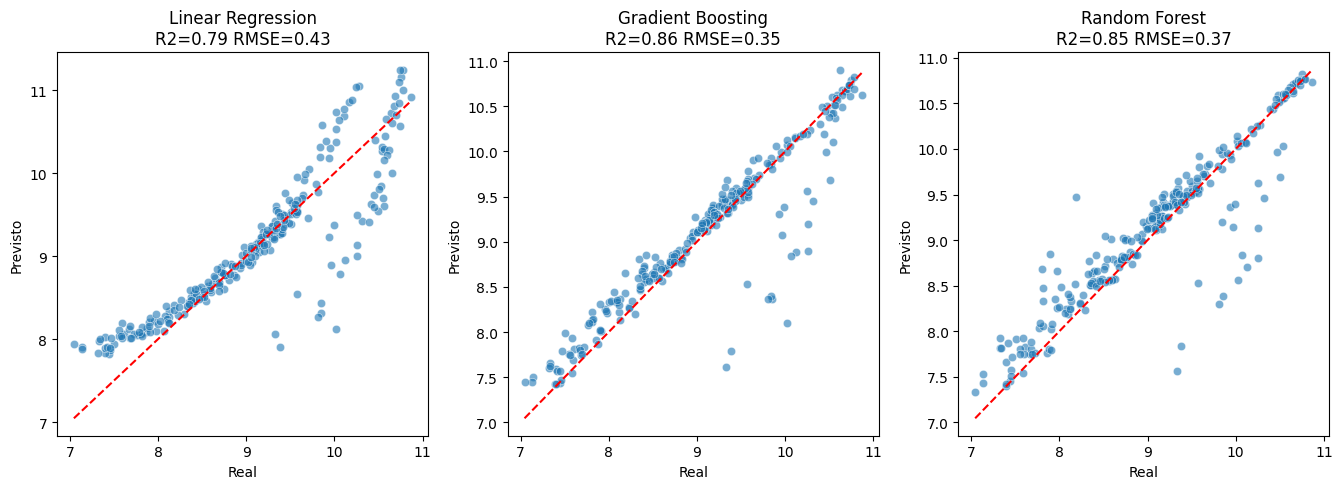

In [115]:
metrics = pd.DataFrame(results).T[['r2', 'rmse', 'mae']]
print(metrics)

plt.figure(figsize=(18, 5))
for idx, (model, data) in enumerate(results.items()):
    plt.subplot(1, 4, idx + 1)
    sns.scatterplot(x=y_test, y=data['y_pred'], alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Real')
    plt.ylabel('Previsto')
    plt.title(f'{model}\nR2={data["r2"]:.2f} RMSE={data["rmse"]:.2f}')
plt.tight_layout()
plt.show()

## Análise Comparativa dos Modelos de Regressão

Três modelos foram avaliados com base em suas previsões: Linear Regression, Gradient Boosting e Random Forest.
Os principais indicadores analisados foram o R² (coeficiente de determinação) e o RMSE (Root Mean Squared Error).

- Linear Regression:
  R² = 0.79 | RMSE = 0.43  
  Modelo simples e interpretável, mas apresentou maior erro nos valores mais altos. Boa aderência linear,
  porém com tendência a subestimar extremos devido à sua natureza linear.

- Gradient Boosting:
  R² = 0.86 | RMSE = 0.35    
  Apresentou o melhor desempenho em R² e RMSE!!!

- Random Forest:
  R² = 0.85 | RMSE = 0.37  
  Quase tão bom quanto o Gradient Boosting, porém ficou um pouco abaixo. 

## Conclusão
O Gradient Boosting foi o que teve a melhor quaidade entre os modelos experimentados e generaliza melhor para dados não vistos, sendo o modelo recomendado para uso final.
